In [1]:
# Libraries.
import matplotlib, matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("paper")

# Setup.
% matplotlib inline

# Paths.
path_data = '../../../data/gatecount_%d/'

In [2]:
# This dataset is now being using

gatecount_1315=pd.read_csv('../../../data/gatecounts_edit_1315.csv')
gatecount_1315.head()

,Unnamed: 0,locationid,entries,exits,servicedate,servicetime_fraction,weekday
0,0,1002,0,1,2013-01-01 00:00:00,3.00,1
1,1,1002,1,0,2013-01-01 00:00:00,5.00,1
2,2,1002,2,0,2013-01-01 00:00:00,5.25,1
3,3,1002,3,0,2013-01-01 00:00:00,5.50,1
4,4,1002,6,0,2013-01-01 00:00:00,5.75,1


In [87]:
%reset out

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Flushing output cache (15 entries)


In [6]:

#call to read in gate_count with all of the processing from other notebook
gate_count=pd.read_csv('../../../data/gatecount_edit.csv')
gate_count.servicedate = pd.to_datetime(gate_count.servicedate)

#fare_count=pd.read_csv('../../../data/fare_count_edit.csv')

#weather_path = '../../../data/weather/wunderground_daily_weather.csv'

#weather = pd.read_csv(weather_path)
#weather.date = pd.to_datetime(weather.date)

gate_count.head()

,Unnamed: 0,locationid,servicedate,entries,exits,servicetime_frac,weekday,month,cold,date,rain,snow,snowfalli
0,0,1002,2014-01-01,1,0,5.25,2,1,True,2014-01-01 00:00:00,0,0,0
1,1,1002,2014-01-01,8,0,5.50,2,1,True,2014-01-01 00:00:00,0,0,0
2,2,1002,2014-01-01,6,0,5.75,2,1,True,2014-01-01 00:00:00,0,0,0
3,3,1002,2014-01-01,16,3,6.00,2,1,True,2014-01-01 00:00:00,0,0,0
4,4,1002,2014-01-01,17,9,6.25,2,1,True,2014-01-01 00:00:00,0,0,0


In [3]:
gate_stations=gatecount_1315.locationid.unique()

# function to preprocess the station id numbers. Only want to keep the stations that appear in gate_count
def is_in_gate_count(id):
    #print id
    if(len(np.where(gate_stations==id)[0])==0):
        return False
    else :
        return True
    

In [4]:
station_info=pd.read_csv('../../../data/Stations.csv')
# remove rows where line==Nan
station_info=station_info[~station_info['line_temp'].isnull()]
# Take out bus stations
station_info=station_info[station_info['line_temp']!='Bus']
# Take out ids that aren't found in gate_count
station_info=station_info[map(is_in_gate_count,station_info['stationid'].values)]

# Remove some columns
station_info=station_info[['stationid','nameshort','namelong','name','line_temp']]
station_info.head()

,stationid,nameshort,namelong,name,line_temp
20,1002,Andrew Square,1002,Andrew Square,Red
21,1004,JFK/U Mass,1004,JFK/U Mass,Red
22,1005,North Quincy,1005,North Quincy,Red
23,1006,Wollaston,1006,Wollaston,Red
24,1007,Quincy Center,1007,Quincy Center,Red


In [126]:
station_info.to_csv('../../../data/Stations_clean.csv')

In [5]:
red_stations=station_info[station_info['line_temp']=='Red']
red_stations_ids=list(red_stations.stationid.values)
# Park is only listed on Green in stations.csv. Want to add it to red because its a junction
red_stations_ids.append(1052)
# Downtown Xing is only listed on Orange in stations.csv. Want to add it to red because its a junction
red_stations_ids.append(1039)
print len(red_stations_ids)


blue_stations=station_info[station_info['line_temp']=='Blue']
blue_stations_ids=list(blue_stations.stationid.values)
# Add govt center junction
blue_stations_ids.append(1051)
# add state st
blue_stations_ids.append(1077)
print len(blue_stations_ids)

green_stations=station_info[station_info['line_temp']=='Green']
green_stations_ids=list(green_stations.stationid.values)
#add haymarket
green_stations_ids.append(1076)
#add north station
green_stations_ids.append(1075)
print len(green_stations_ids)

orange_stations=station_info[station_info['line_temp']=='Orange']
orange_stations_ids=list(orange_stations.stationid.values)
print len(orange_stations_ids)



22
12
14
19


In [6]:
from sklearn import preprocessing

In [9]:
gatecount_1315.head()

,Unnamed: 0,locationid,entries,exits,servicedate,servicetime_fraction,weekday
0,0,1002,0,1,2013-01-01 00:00:00,3.00,1
1,1,1002,1,0,2013-01-01 00:00:00,5.00,1
2,2,1002,2,0,2013-01-01 00:00:00,5.25,1
3,3,1002,3,0,2013-01-01 00:00:00,5.50,1
4,4,1002,6,0,2013-01-01 00:00:00,5.75,1


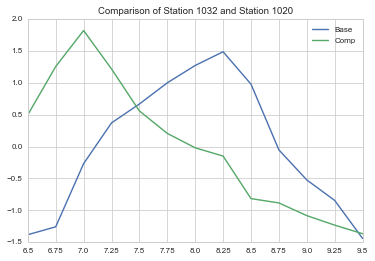

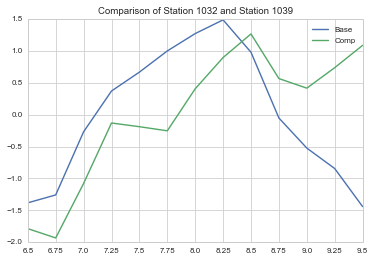

[0.96125839255472789,
 0.95301927370852202,
 0.99294202938227449,
 0.84034395276764939,
 0.93617937383562988,
 0.90620841322552326,
 0.065628032430363276,
 1.0,
 0.92898560028348842,
 0.87779707839383492,
 0.78867498634429056,
 0.73466883015396889,
 0.68810385936475627,
 0.95413436525674933,
 0.58072419127665975,
 0.82061509074653627,
 0.73213365449875589,
 0.93571848838013816,
 0.93155347132017363,
 0.73088616982439736,
 0.62408526403909381,
 0.41660374836219571]

In [11]:
## Want to compare portions of time series across various stations. 

def compare_series(station_id,comparison_station=False,begin_time=4.5,end_time=9.5, print_plot=False):
    
    if(not comparison_station):
        comparison_station=[station_id]
    
    station_records=gatecount_1315[gatecount_1315['weekday']<5]
    station_records=station_records[(station_records['servicetime_fraction']<=end_time) & (station_records['servicetime_fraction']>=begin_time) ]
    #get subset of station 
    base_records=station_records[(station_records['locationid']==station_id)]
    base_grouping=base_records[['servicetime_fraction','servicedate','entries']].groupby('servicetime_fraction')
    base_entries=base_grouping.agg(np.mean)['entries']
    
    # Standardize the entries so we can indentify stations with similar behavior without worrying about scale
    base_entries_scaled=preprocessing.scale(base_entries)
    
    correlations=[]
    count=0
    
    for station in comparison_station:
        
        comp_records=station_records[(station_records['locationid']==station)]
        comp_grouping=comp_records[['servicetime_fraction','servicedate','entries']].groupby('servicetime_fraction')
        comp_entries=comp_grouping.agg(np.mean)['entries']
        
        comp_entries_scaled=preprocessing.scale(comp_entries)
        
        # np.correlate for two series of the same length returns a correlation which is <= length of the two series
        # since each pairwise comparison of the terms can yield an individual correlation of 1. Want to think of correlation
        # of series from [-1,1] so I divided by the length of the series
        correlations.append((np.correlate(base_entries_scaled,comp_entries_scaled)*1.0/len(base_entries_scaled))[0])
        
        # Print dissimilar stations
        if(print_plot& (correlations[count]<0.45)):
            plt.plot(base_entries_scaled,label='Base')
            plt.plot(comp_entries_scaled,label='Comp')
            plt.title('Comparison of Station '+str(station_id)+' and Station '+str(station))
            plt.legend()
            plt.xticks(range(13), list(comp_entries.index))
            plt.show()
        count+=1

        
        
    return correlations

compare_series(1032,comparison_station=red_stations_ids,begin_time=6.5,end_time=9.5,print_plot=True)

In [196]:
## Example: comparing Alewife and Forest Hills, both of which are terminal stations outside the city with bus connections
# running into them. Would expect similar behavior from the two. 

#sanity check: comparison for station 1032 should be 1.0 since it's the same as our base station
# station 1087: Forest Hills. 1077: State Street. 1052: Park.

all_correlations_1032=compare_series(1032,comparison_station=red_stations_ids,
                                     begin_time=5.,end_time=19.5)

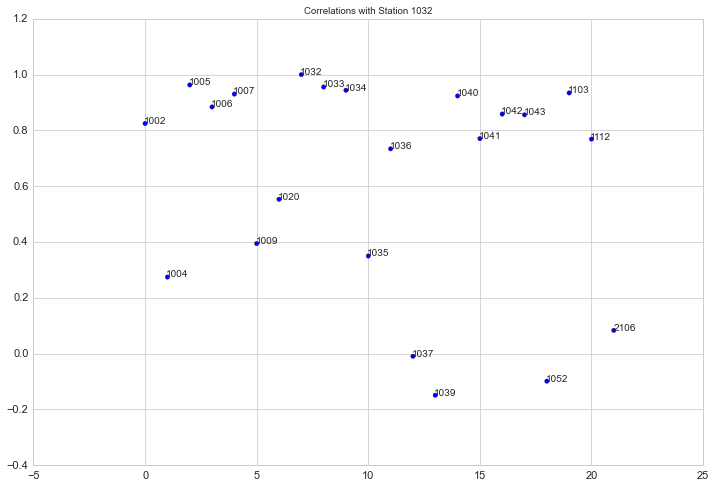

In [198]:
correlations_df=pd.DataFrame(zip(red_stations_ids,all_correlations_1032))
correlations_df=correlations_df.sort([0])

labels=list(correlations_df[0].values)
xs=range(len(correlations_df))
ys=list(correlations_df[1].values)

plt.figure(figsize=(12,8))
plt.scatter(xs,ys)
plt.title('Correlations with Station 1032')

for i, txt in enumerate(labels):
    plt.annotate(txt, (i,ys[i]))
    

In [12]:
temp_ids=red_stations_ids

temp_ids.sort()

correlation_vectors=[]

for station in temp_ids:
    print station
    output=compare_series(station,comparison_station=temp_ids,begin_time=5.,end_time=19.5)
    
    correlations_df=pd.DataFrame(zip(temp_ids,output))
    #correlations_df=correlations_df.sort([0])

    correlation_vectors.append(list(correlations_df[1].values))
    

1002
1004
1005
1006
1007
1009
1020
1032
1033
1034
1035
1036
1037
1039
1040
1041
1042
1043
1052
1103
1112
2106


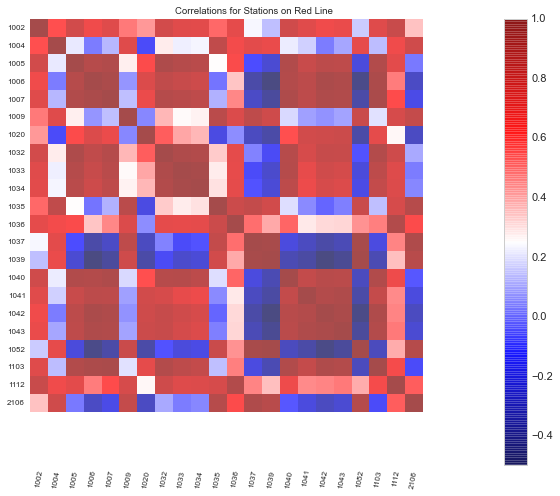

In [13]:

fig, ax = plt.subplots()
heatmap = ax.pcolor(pd.DataFrame(correlation_vectors),cmap=plt.get_cmap('seismic'),alpha=0.7)
fig = plt.gcf()
fig.set_size_inches(10,8)

ax.invert_yaxis()
ax.grid(False)
ax.set_frame_on(False)

ax.set_yticks(np.arange(len(temp_ids)) + 0.5, minor=False)
ax.set_xticks(np.arange(len(temp_ids))+0.5, minor=False) 

ax.set_xticklabels(temp_ids, minor=False)
ax.set_yticklabels(temp_ids, minor=False)

plt.xticks(rotation=80)
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)
plt.title('Correlations for Stations on Red Line')
colorbar=plt.colorbar(heatmap)

plt.show()



##PCA and K-means Clustering

##Red Line Stations

###Idea:

Cluster the stations by taking their scaled mean entries at each time interval as a feature in our parameter space. Those stations with similar scaled mean entries will lie closer to one another in this higher dimensional space. Naturally, there will be some intervals which will contain more variation than the others. We can use PCA to reduce the dimensionality of our space and therefore get better measures of distance (or similarity) in the space. Once in the transformed space, run k-means or some other unsupervised clustering algorithm to group the stations. The idea is that we can perform the a priori clustering before the creation of the similarity matrix above, then order the rows so that similar rows are grouped together. Theoretically, this should bring those stations with greater correlation closer together and their pariwise comparisons closer to the diagonal in the matrix.

In [14]:
from sklearn.decomposition import PCA

In [17]:

def get_name(station_id):
    return(station_info[station_info['stationid']==station_id]['name'].values[0])


In [20]:
# For each station
def get_scaled_entries(station_ids,begin_time=5,end_time=19.5):

    vector_entries_scaled=[]
    
    for station in station_ids:
        station_records=gatecount_1315[gatecount_1315['weekday']<5]
        station_records=station_records[(station_records['servicetime_fraction']<=end_time) & (station_records['servicetime_fraction']>=begin_time) ]

        #get subset of station 
        base_records=station_records[(station_records['locationid']==station)]
        base_grouping=base_records[['servicetime_fraction','servicedate','entries']].groupby('servicetime_fraction')
        base_entries=base_grouping.agg(np.mean)['entries']

        entries_scaled=preprocessing.scale(base_entries)
        
        vector_entries_scaled.append(list(entries_scaled))
        
    return vector_entries_scaled
    
    ## now for each station, have a vector of scaled entries over the window of interest.
    
c=get_scaled_entries(red_stations_ids)    
        

In [21]:
print "Number of stations: "+str(len(c))
print "Number of time intervals: "+str(len(c[0]))

pca = PCA(n_components=10)
pca.fit(c)

print "Number of PCA components: "+str(len(pca.components_))
print(pca.explained_variance_ratio_) 


Number of stations: 22
Number of time intervals: 59
Number of PCA components: 10
[ 0.77756367  0.12088187  0.04385288  0.01986184  0.00946769  0.00579901
  0.00506189  0.00342932  0.00266491  0.00194105]


In [22]:
pca = PCA(n_components=4)
pca.fit(c)

c_transformed=pca.transform(c)

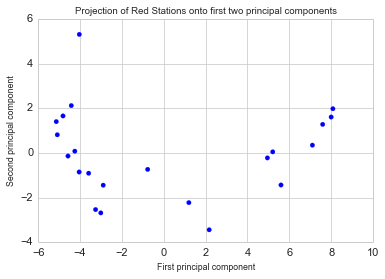

In [23]:
#Visualize the plot of first two principal components
components_transposed=c_transformed.transpose()

plt.scatter(components_transposed[0],components_transposed[1],color='blue',label='Stations')
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('Projection of Red Stations onto first two principal components')
plt.show()

###Comments:
It seems that we can capture almost 90% of the variation using only 2 principal components. I will perform PCA with 4 components for now. Above is the plot of the first two components comprising of the majority of the variation. This is an unsupervised clustering task and I'm not sure how many groups to cluster the stations into. Based on the plot above, it seems that we can used k=3 clusters as a reasonable starting point. I'm not too concerned whether k=2,3, or 4 is the best choice because it's all in an effort to group similar stations closer together on the similarity matrix for easier representation. Thus, the visual differences between k=2,3,4 won't be too stark.

In [24]:
from sklearn import cluster

[[ 0.86643261 -2.13594796  0.59919662  1.08038903]
 [-4.09453351  0.23384375 -0.19992251 -0.18436462]
 [ 6.64787203  0.51453127  0.08592574 -0.14697023]]


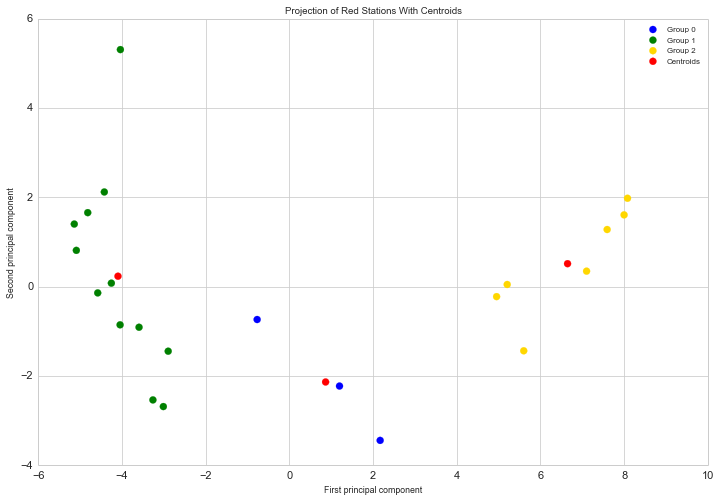

In [29]:
cluster_fn=cluster.KMeans(n_clusters=3)
cluster_fn.fit(c_transformed)

print cluster_fn.cluster_centers_

clusters=cluster_fn.cluster_centers_.transpose()
components_transposed=c_transformed.transpose()

#get the groupings
group0=cluster_fn.labels_==0
group1=cluster_fn.labels_==1
group2=cluster_fn.labels_==2

plt.figure(figsize=(12,8))
plt.scatter(components_transposed[0][group0],components_transposed[1][group0],s=50,color='blue',label='Group 0')
plt.scatter(components_transposed[0][group1],components_transposed[1][group1],s=50,color='green',label='Group 1')
plt.scatter(components_transposed[0][group2],components_transposed[1][group2],s=50,color='gold',label='Group 2') 
plt.scatter(clusters[0],clusters[1],color='red',label='Centroids',s=50)
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('Projection of Red Stations With Centroids')
plt.legend()
plt.show()

###Comments:

The centroids look pretty reasonable. Going to continue with k=3 and see what the similarity matrix ends up looking like

In [30]:
group_0_ids=np.array(red_stations_ids)[group0]
print "First grouping: "+str(group_0_ids)
group_1_ids=np.array(red_stations_ids)[group1]
print "Second grouping: "+str(group_1_ids)
group_2_ids=np.array(red_stations_ids)[group2]
print "Third grouping: "+str(group_2_ids)

#reorder the IDS so that the similarity matrix has like-grouped ids near each other
reordered_ids=list(group_1_ids)+list(group_0_ids)+list(group_2_ids)
print "Re-ordered ID list: "+str(reordered_ids)


First grouping: [1002 1036 1112]
Second grouping: [1005 1006 1007 1020 1032 1033 1034 1040 1041 1042 1043 1103]
Third grouping: [1004 1009 1035 1037 1039 1052 2106]
Re-ordered ID list: [1005, 1006, 1007, 1020, 1032, 1033, 1034, 1040, 1041, 1042, 1043, 1103, 1002, 1036, 1112, 1004, 1009, 1035, 1037, 1039, 1052, 2106]


##New Similarity Matrix

Now let's build the similarity matrix, this time ordering the axes according to our reordered ID list

In [31]:
'''fig, ax = plt.subplots()
heatmap = ax.pcolor(batter_df[cols],cmap=plt.get_cmap('seismic'),alpha=0.7)
fig = plt.gcf()'''

temp_ids=reordered_ids

correlation_vectors=[]

for station in temp_ids:
    print station
    output=compare_series(station,comparison_station=temp_ids,begin_time=5.,end_time=19.5)
    
    correlations_df=pd.DataFrame(zip(temp_ids,output))

    correlation_vectors.append(list(correlations_df[1].values))    
    

1005
1006
1007
1020
1032
1033
1034
1040
1041
1042
1043
1103
1002
1036
1112
1004
1009
1035
1037
1039
1052
2106


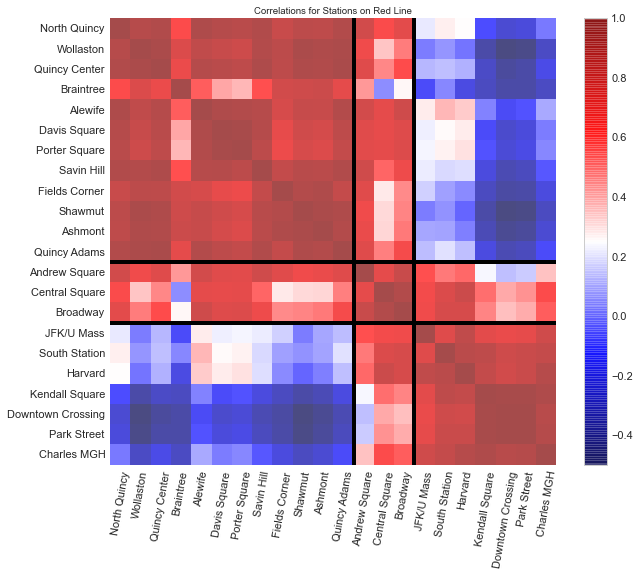

In [32]:
station_names=map(get_name,temp_ids)

fig, ax = plt.subplots()
heatmap = ax.pcolor(pd.DataFrame(correlation_vectors),cmap=plt.get_cmap('seismic'),alpha=0.7)
fig = plt.gcf()
fig.set_size_inches(10,8)

# Clip the axes to remove white border
plt.ylim(0, len(temp_ids))
plt.xlim(0, len(temp_ids))

#invert so we orient the diagonal properly
ax.invert_yaxis()
ax.grid(False)
ax.set_frame_on(False)

# reorganize the ticks
ax.set_yticks(np.arange(len(temp_ids)) + 0.5, minor=False)
ax.set_xticks(np.arange(len(temp_ids))+0.5, minor=False) 
#put labels on the ticks
ax.set_xticklabels(station_names, minor=False)
ax.set_yticklabels(station_names, minor=False)

plt.xticks(rotation=80)
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)
plt.title('Correlations for Stations on Red Line')
colorbar=plt.colorbar(heatmap)

# plot lines for the groups
plt.axhline(y=len(group_1_ids),xmin=0,xmax=(len(temp_ids)-15),color='black',linewidth=4)
plt.axhline(y=len(group_1_ids)+len(group_0_ids),xmin=0,xmax=(len(temp_ids)-15),color='black',linewidth=4)

plt.axvline(x=len(group_1_ids),ymin=0,ymax=(len(temp_ids)-15),color='black',linewidth=4)
plt.axvline(x=len(group_0_ids)+len(group_1_ids),ymin=0,ymax=(len(temp_ids)-15),color='black',linewidth=4)


plt.show()


###Green Stations

In [33]:
## green scaled entries    
c=get_scaled_entries(green_stations_ids)    
        
print "Number of stations: "+str(len(c))
print "Number of time intervals: "+str(len(c[0]))

pca = PCA(n_components=10)
pca.fit(c)

print "Number of PCA components: "+str(len(pca.components_))
print(pca.explained_variance_ratio_) 


Number of stations: 14
Number of time intervals: 59
Number of PCA components: 10
[ 0.70666128  0.15291648  0.05047327  0.03086441  0.02673166  0.01110493
  0.00873607  0.00620418  0.00259329  0.00130377]


###Comments: 
3 principal components account for 90% of the variation in the dataset. Like with the red lines, going to use PCA with 4 components just to be safe.

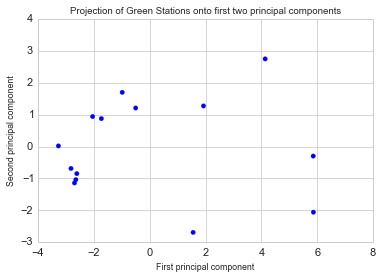

In [34]:

pca = PCA(n_components=4)
pca.fit(c)

c_transformed=pca.transform(c)

#Visualize the plot of first two principal components
components_transposed=c_transformed.transpose()

plt.scatter(components_transposed[0],components_transposed[1],color='blue',label='Stations')
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('Projection of Green Stations onto first two principal components')
plt.show()

###Comments:

Seems like 3 clusters may be sufficient again.

[[ 5.86167307 -1.17921854  0.93484901  0.15354039]
 [-2.14871859  0.11435034  0.15370392 -0.00732814]
 [ 2.53837372  0.44309467 -1.08434443 -0.08037585]]


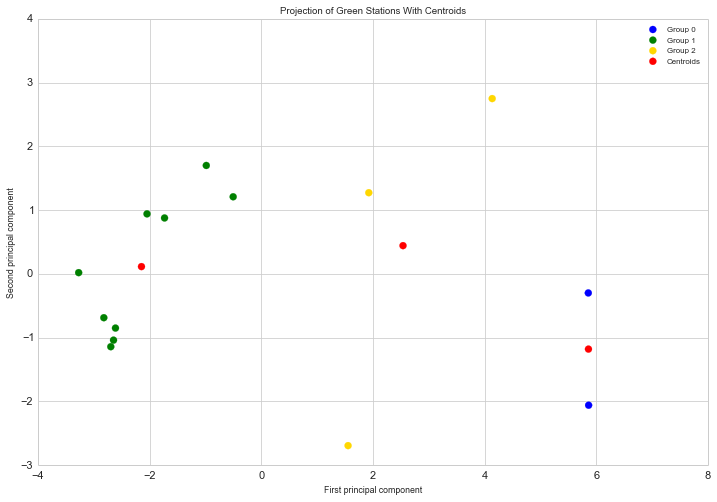

In [35]:
cluster_fn=cluster.KMeans(n_clusters=3)
cluster_fn.fit(c_transformed)

print cluster_fn.cluster_centers_

clusters=cluster_fn.cluster_centers_.transpose()
components_transposed=c_transformed.transpose()

#get the groupings
group0=cluster_fn.labels_==0
group1=cluster_fn.labels_==1
group2=cluster_fn.labels_==2
#group3=cluster_fn.labels_==3

plt.figure(figsize=(12,8))
plt.scatter(components_transposed[0][group0],components_transposed[1][group0],s=50,color='blue',label='Group 0')
plt.scatter(components_transposed[0][group1],components_transposed[1][group1],s=50,color='green',label='Group 1')
plt.scatter(components_transposed[0][group2],components_transposed[1][group2],s=50,color='gold',label='Group 2') 
#plt.scatter(components_transposed[0][group3],components_transposed[1][group3],s=50,color='brown',label='Group 3') 
plt.scatter(clusters[0],clusters[1],color='red',label='Centroids',s=50)
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('Projection of Green Stations With Centroids')
plt.legend()
plt.show()

In [36]:
group_0_ids=np.array(green_stations_ids)[group0]
print "First grouping: "+str(group_0_ids)
group_1_ids=np.array(green_stations_ids)[group1]
print "Second grouping: "+str(group_1_ids)
group_2_ids=np.array(green_stations_ids)[group2]
print "Third grouping: "+str(group_2_ids)

#reorder the IDS so that the similarity matrix has like-grouped ids near each other
reordered_ids=list(group_1_ids)+list(group_2_ids)+list(group_0_ids)
print "Re-ordered ID list: "+str(reordered_ids)

First grouping: [1101 1075]
Second grouping: [1051 1052 1053 1054 1055 1057 1058 1059 1060]
Third grouping: [1056 1061 1076]
Re-ordered ID list: [1051, 1052, 1053, 1054, 1055, 1057, 1058, 1059, 1060, 1056, 1061, 1076, 1101, 1075]


In [37]:

temp_ids=reordered_ids

correlation_vectors=[]

for station in temp_ids:
    print station
    output=compare_series(station,comparison_station=temp_ids,begin_time=5.,end_time=19.5)
    
    correlations_df=pd.DataFrame(zip(temp_ids,output))

    correlation_vectors.append(list(correlations_df[1].values))    
    

1051
1052
1053
1054
1055
1057
1058
1059
1060
1056
1061
1076
1101
1075


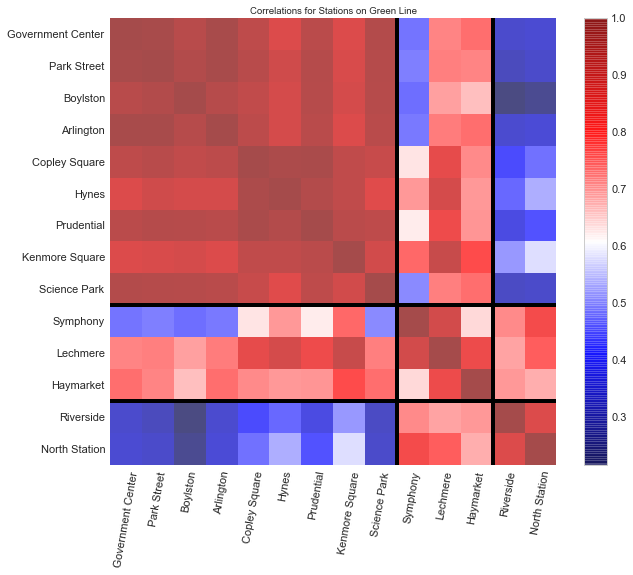

In [38]:
station_names=map(get_name,temp_ids)

fig, ax = plt.subplots()
heatmap = ax.pcolor(pd.DataFrame(correlation_vectors),cmap=plt.get_cmap('seismic'),alpha=0.7)
fig = plt.gcf()
fig.set_size_inches(10,8)

# Clip the axes to remove white border
plt.ylim(0, len(temp_ids))
plt.xlim(0, len(temp_ids))

#invert so we orient the diagonal properly
ax.invert_yaxis()
ax.grid(False)
ax.set_frame_on(False)

# reorganize the ticks
ax.set_yticks(np.arange(len(temp_ids)) + 0.5, minor=False)
ax.set_xticks(np.arange(len(temp_ids))+0.5, minor=False) 
#put labels on the ticks
ax.set_xticklabels(station_names, minor=False)
ax.set_yticklabels(station_names, minor=False)

plt.xticks(rotation=80)
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)
plt.title('Correlations for Stations on Green Line')
colorbar=plt.colorbar(heatmap)

# plot lines for the groups
plt.axhline(y=len(group_1_ids),xmin=0,xmax=(len(temp_ids)),color='black',linewidth=4)
plt.axhline(y=len(group_1_ids)+len(group_2_ids),xmin=0,xmax=(len(temp_ids)),color='black',linewidth=4)

plt.axvline(x=len(group_1_ids),ymin=0,ymax=(len(temp_ids)),color='black',linewidth=4)
plt.axvline(x=len(group_1_ids)+len(group_2_ids),ymin=0,ymax=(len(temp_ids)),color='black',linewidth=4)


plt.show()


##Blue Lines

In [39]:
## green scaled entries    
c=get_scaled_entries(blue_stations_ids)    
        
print "Number of stations: "+str(len(c))
print "Number of time intervals: "+str(len(c[0]))

pca = PCA(n_components=10)
pca.fit(c)

print "Number of PCA components: "+str(len(pca.components_))
print(pca.explained_variance_ratio_) 


Number of stations: 12
Number of time intervals: 59
Number of PCA components: 10
[ 0.90825734  0.03835394  0.01730337  0.00929305  0.00771629  0.00595549
  0.00415006  0.00357851  0.00301575  0.00195743]


###Comments:
90% of the variation is captured with one principal component. I'll reduce my parameter space to two dimensions.

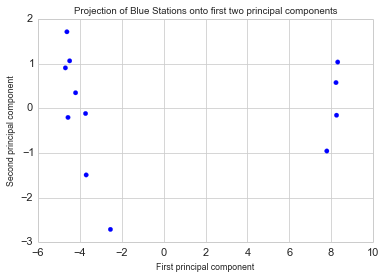

In [40]:

pca = PCA(n_components=2)
pca.fit(c)

c_transformed=pca.transform(c)

#Visualize the plot of first two principal components
components_transposed=c_transformed.transpose()

plt.scatter(components_transposed[0],components_transposed[1],color='blue',label='Stations')
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('Projection of Blue Stations onto first two principal components')
plt.show()

###Comments:
Two clusters is definitely enough.

[[ 8.1496409   0.12471314]
 [-4.07482045 -0.06235657]]


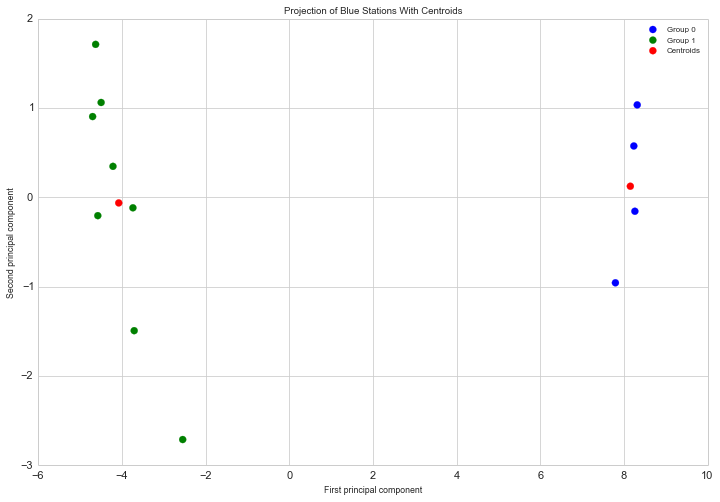

In [42]:
cluster_fn=cluster.KMeans(n_clusters=2)
cluster_fn.fit(c_transformed)

print cluster_fn.cluster_centers_

clusters=cluster_fn.cluster_centers_.transpose()
components_transposed=c_transformed.transpose()

#get the groupings
group0=cluster_fn.labels_==0
group1=cluster_fn.labels_==1

plt.figure(figsize=(12,8))
plt.scatter(components_transposed[0][group0],components_transposed[1][group0],s=50,color='blue',label='Group 0')
plt.scatter(components_transposed[0][group1],components_transposed[1][group1],s=50,color='green',label='Group 1')
plt.scatter(clusters[0],clusters[1],color='red',label='Centroids',s=50)
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('Projection of Blue Stations With Centroids')
plt.legend()
plt.show()

In [43]:
group_0_ids=np.array(blue_stations_ids)[group0]
print "First grouping: "+str(group_0_ids)
group_1_ids=np.array(blue_stations_ids)[group1]
print "Second grouping: "+str(group_1_ids)


#reorder the IDS so that the similarity matrix has like-grouped ids near each other
reordered_ids=list(group_1_ids)+list(group_0_ids)
print "Re-ordered ID list: "+str(reordered_ids)
temp_ids=reordered_ids

correlation_vectors=[]

for station in temp_ids:
    print station
    output=compare_series(station,comparison_station=temp_ids,begin_time=5.,end_time=19.5)
    
    correlations_df=pd.DataFrame(zip(temp_ids,output))

    correlation_vectors.append(list(correlations_df[1].values))    
    

First grouping: [1012 1019 1051 1077]
Second grouping: [1010 1011 1013 1014 1015 1016 1017 1018]
Re-ordered ID list: [1010, 1011, 1013, 1014, 1015, 1016, 1017, 1018, 1012, 1019, 1051, 1077]
1010
1011
1013
1014
1015
1016
1017
1018
1012
1019
1051
1077


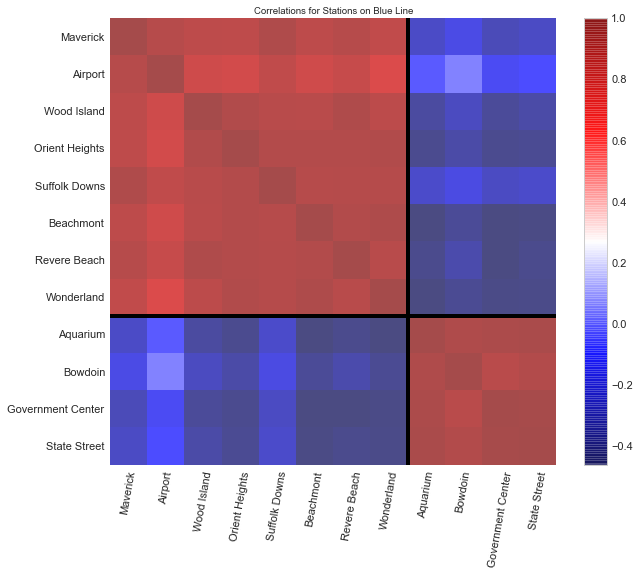

In [44]:
station_names=map(get_name,temp_ids)

fig, ax = plt.subplots()
heatmap = ax.pcolor(pd.DataFrame(correlation_vectors),cmap=plt.get_cmap('seismic'),alpha=0.7)
fig = plt.gcf()
fig.set_size_inches(10,8)

# Clip the axes to remove white border
plt.ylim(0, len(temp_ids))
plt.xlim(0, len(temp_ids))

#invert so we orient the diagonal properly
ax.invert_yaxis()
ax.grid(False)
ax.set_frame_on(False)

# reorganize the ticks
ax.set_yticks(np.arange(len(temp_ids)) + 0.5, minor=False)
ax.set_xticks(np.arange(len(temp_ids))+0.5, minor=False) 
#put labels on the ticks
ax.set_xticklabels(station_names, minor=False)
ax.set_yticklabels(station_names, minor=False)

plt.xticks(rotation=80)
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)
plt.title('Correlations for Stations on Blue Line')
colorbar=plt.colorbar(heatmap)

# plot lines for the groups
plt.axhline(y=len(group_1_ids),xmin=0,xmax=(len(temp_ids)),color='black',linewidth=4)

plt.axvline(x=len(group_1_ids),ymin=0,ymax=(len(temp_ids)),color='black',linewidth=4)


plt.show()


##Orange Stations

In [94]:
## green scaled entries    
c=get_scaled_entries(orange_stations_ids)    
        
print "Number of stations: "+str(len(c))
print "Number of time intervals: "+str(len(c[0]))

pca = PCA(n_components=10)
pca.fit(c)

print "Number of PCA components: "+str(len(pca.components_))
print(pca.explained_variance_ratio_) 


Number of stations: 19
Number of time intervals: 59
Number of PCA components: 10
[ 0.78397383  0.06836642  0.05341448  0.03464654  0.01826433  0.01317482
  0.00887342  0.00673241  0.00315521  0.00264334]


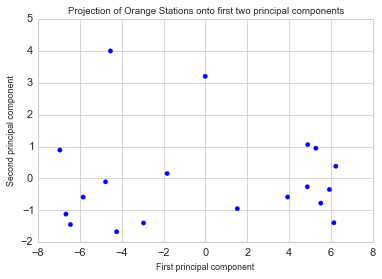

In [95]:

pca = PCA(n_components=4)
pca.fit(c)

c_transformed=pca.transform(c)

#Visualize the plot of first two principal components
components_transposed=c_transformed.transpose()

plt.scatter(components_transposed[0],components_transposed[1],color='blue',label='Stations')
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('Projection of Orange Stations onto first two principal components')
plt.show()

###Comments:
Consider using k=3 clusters

[[-5.64043167 -0.00608484 -0.58744744 -0.13036626]
 [ 5.34574341 -0.12105565 -0.39327983  0.01162935]
 [-0.8207314   0.25275978  1.81459269  0.20488226]]


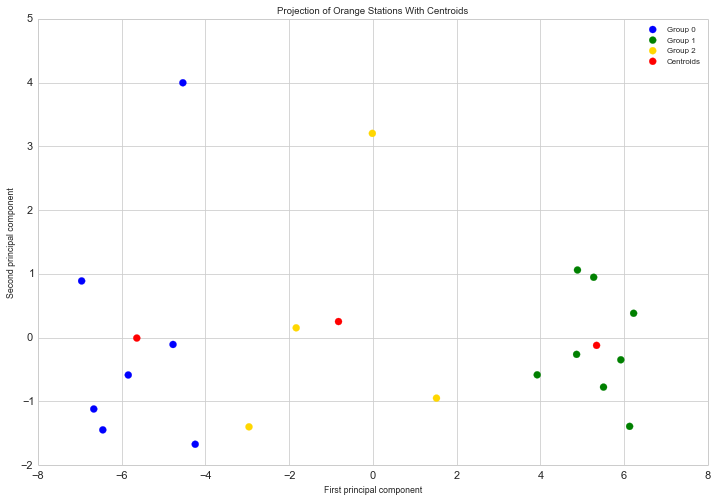

In [103]:
cluster_fn=cluster.KMeans(n_clusters=3)
cluster_fn.fit(c_transformed)

print cluster_fn.cluster_centers_

clusters=cluster_fn.cluster_centers_.transpose()
components_transposed=c_transformed.transpose()

#get the groupings
group0=cluster_fn.labels_==0
group1=cluster_fn.labels_==1
group2=cluster_fn.labels_==2


plt.figure(figsize=(12,8))
plt.scatter(components_transposed[0][group0],components_transposed[1][group0],s=50,color='blue',label='Group 0')
plt.scatter(components_transposed[0][group1],components_transposed[1][group1],s=50,color='green',label='Group 1')
plt.scatter(components_transposed[0][group2],components_transposed[1][group2],s=50,color='gold',label='Group 2')
plt.scatter(clusters[0],clusters[1],color='red',label='Centroids',s=50)
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('Projection of Orange Stations With Centroids')
plt.legend()
plt.show()

In [104]:
group_0_ids=np.array(orange_stations_ids)[group0]
print "First grouping: "+str(group_0_ids)
group_1_ids=np.array(orange_stations_ids)[group1]
print "Second grouping: "+str(group_1_ids)
group_2_ids=np.array(orange_stations_ids)[group2]
print "Third grouping: "+str(group_2_ids)


#reorder the IDS so that the similarity matrix has like-grouped ids near each other
reordered_ids=list(group_0_ids)+list(group_2_ids)+list(group_1_ids)
print "Re-ordered ID list: "+str(reordered_ids)
temp_ids=reordered_ids

correlation_vectors=[]

for station in temp_ids:
    print station
    output=compare_series(station,comparison_station=temp_ids,begin_time=5.,end_time=19.5)
    
    correlations_df=pd.DataFrame(zip(temp_ids,output))

    correlation_vectors.append(list(correlations_df[1].values))    
    

First grouping: [1039 1074 1077 1078 1079 1080 1082]
Second grouping: [1070 1071 1072 1073 1084 1085 1086 1087]
Third grouping: [1075 1076 1081 1083]
Re-ordered ID list: [1039, 1074, 1077, 1078, 1079, 1080, 1082, 1075, 1076, 1081, 1083, 1070, 1071, 1072, 1073, 1084, 1085, 1086, 1087]
1039
1074
1077
1078
1079
1080
1082
1075
1076
1081
1083
1070
1071
1072
1073
1084
1085
1086
1087


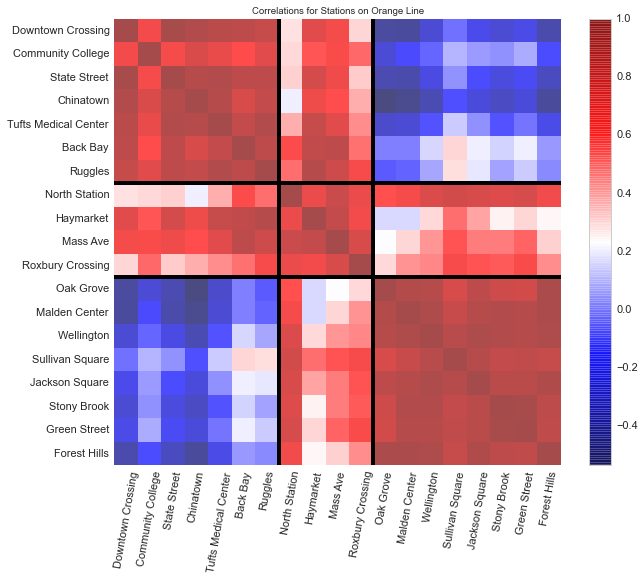

In [105]:
station_names=map(get_name,temp_ids)

fig, ax = plt.subplots()
heatmap = ax.pcolor(pd.DataFrame(correlation_vectors),cmap=plt.get_cmap('seismic'),alpha=0.7)
fig = plt.gcf()
fig.set_size_inches(10,8)

# Clip the axes to remove white border
plt.ylim(0, len(temp_ids))
plt.xlim(0, len(temp_ids))

#invert so we orient the diagonal properly
ax.invert_yaxis()
ax.grid(False)
ax.set_frame_on(False)

# reorganize the ticks
ax.set_yticks(np.arange(len(temp_ids)) + 0.5, minor=False)
ax.set_xticks(np.arange(len(temp_ids))+0.5, minor=False) 
#put labels on the ticks
ax.set_xticklabels(station_names, minor=False)
ax.set_yticklabels(station_names, minor=False)

plt.xticks(rotation=80)
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)
plt.title('Correlations for Stations on Orange Line')
colorbar=plt.colorbar(heatmap)

# plot lines for the groups
plt.axhline(y=len(group_0_ids),xmin=0,xmax=(len(temp_ids)),color='black',linewidth=4)
plt.axhline(y=len(group_0_ids)+len(group_2_ids),xmin=0,xmax=(len(temp_ids)),color='black',linewidth=4)

plt.axvline(x=len(group_0_ids),ymin=0,ymax=(len(temp_ids)),color='black',linewidth=4)
plt.axvline(x=len(group_0_ids)+len(group_2_ids),ymin=0,ymax=(len(temp_ids)),color='black',linewidth=4)


plt.show()


#All Stations

Try to run similarity matrix across all stations, see if we can cluster.

In [109]:
all_ids=orange_stations_ids+blue_stations_ids+red_stations_ids+green_stations_ids

In [110]:

c=get_scaled_entries(all_ids)    
        
print "Number of stations: "+str(len(c))
print "Number of time intervals: "+str(len(c[0]))

pca = PCA(n_components=10)
pca.fit(c)

print "Number of PCA components: "+str(len(pca.components_))
print(pca.explained_variance_ratio_) 


Number of stations: 67
Number of time intervals: 59
Number of PCA components: 10
[ 0.79430153  0.07933529  0.03933715  0.02921026  0.01094845  0.00869538
  0.00625548  0.00486287  0.00464133  0.00350084]


###Comments:
90% of variation is captured in only two principal components. I'm going to keep 4 components.

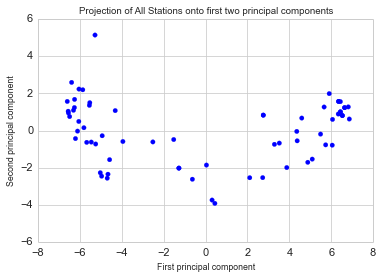

In [111]:

pca = PCA(n_components=4)
pca.fit(c)

c_transformed=pca.transform(c)

#Visualize the plot of first two principal components
components_transposed=c_transformed.transpose()

plt.scatter(components_transposed[0],components_transposed[1],color='blue',label='Stations')
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('Projection of All Stations onto first two principal components')
plt.show()

[[ 5.49045892  0.40392596  0.02161905 -0.05701207]
 [-5.62888594  0.37809589  0.15954156 -0.2028939 ]
 [-0.16145022 -2.23005376 -0.50941159  0.73343793]]


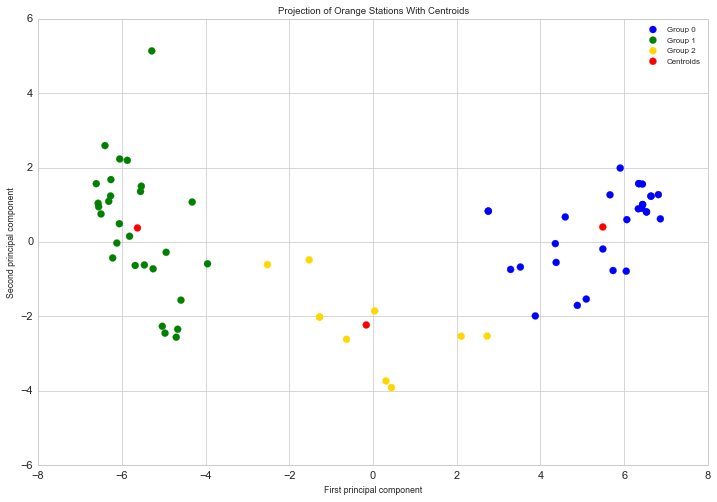

In [115]:
cluster_fn=cluster.KMeans(n_clusters=3)
cluster_fn.fit(c_transformed)

print cluster_fn.cluster_centers_

clusters=cluster_fn.cluster_centers_.transpose()
components_transposed=c_transformed.transpose()

#get the groupings
group0=cluster_fn.labels_==0
group1=cluster_fn.labels_==1
group2=cluster_fn.labels_==2
#group3=cluster_fn.labels_==3


plt.figure(figsize=(12,8))
plt.scatter(components_transposed[0][group0],components_transposed[1][group0],s=50,color='blue',label='Group 0')
plt.scatter(components_transposed[0][group1],components_transposed[1][group1],s=50,color='green',label='Group 1')
plt.scatter(components_transposed[0][group2],components_transposed[1][group2],s=50,color='gold',label='Group 2')
#plt.scatter(components_transposed[0][group3],components_transposed[1][group3],s=50,color='purple',label='Group 3')
plt.scatter(clusters[0],clusters[1],color='red',label='Centroids',s=50)
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('Projection of Orange Stations With Centroids')
plt.legend()
plt.show()

In [116]:
group_0_ids=np.array(all_ids)[group0]
print "First grouping: "+str(group_0_ids)
group_1_ids=np.array(all_ids)[group1]
print "Second grouping: "+str(group_1_ids)
group_2_ids=np.array(all_ids)[group2]
print "Third grouping: "+str(group_2_ids)



#reorder the IDS so that the similarity matrix has like-grouped ids near each other
reordered_ids=list(group_1_ids)+list(group_2_ids)+list(group_0_ids)
print "Re-ordered ID list: "+str(reordered_ids)
temp_ids=reordered_ids

correlation_vectors=[]
count=0
for station in temp_ids:
    if(count%5==0):
        print station
        
    count+=1
    output=compare_series(station,comparison_station=temp_ids,begin_time=5.,end_time=19.5)
    
    correlations_df=pd.DataFrame(zip(temp_ids,output))

    correlation_vectors.append(list(correlations_df[1].values))    
    

First grouping: [1039 1074 1076 1077 1078 1079 1080 1082 1012 1019 1051 1077 1004 1009 1035
 1037 1039 1052 2106 1051 1052 1053 1054 1055 1057 1058 1059 1060 1076]
Second grouping: [1070 1071 1072 1073 1084 1085 1086 1087 1010 1011 1013 1014 1015 1016 1017
 1018 1005 1006 1007 1020 1032 1033 1034 1040 1041 1042 1043 1103]
Third grouping: [1075 1081 1083 1002 1036 1112 1056 1061 1101 1075]
Re-ordered ID list: [1070, 1071, 1072, 1073, 1084, 1085, 1086, 1087, 1010, 1011, 1013, 1014, 1015, 1016, 1017, 1018, 1005, 1006, 1007, 1020, 1032, 1033, 1034, 1040, 1041, 1042, 1043, 1103, 1075, 1081, 1083, 1002, 1036, 1112, 1056, 1061, 1101, 1075, 1039, 1074, 1076, 1077, 1078, 1079, 1080, 1082, 1012, 1019, 1051, 1077, 1004, 1009, 1035, 1037, 1039, 1052, 2106, 1051, 1052, 1053, 1054, 1055, 1057, 1058, 1059, 1060, 1076]
1070
1085
1013
1018
1032
1042
1083
1061
1076
1082
1004
1052
1054
1060


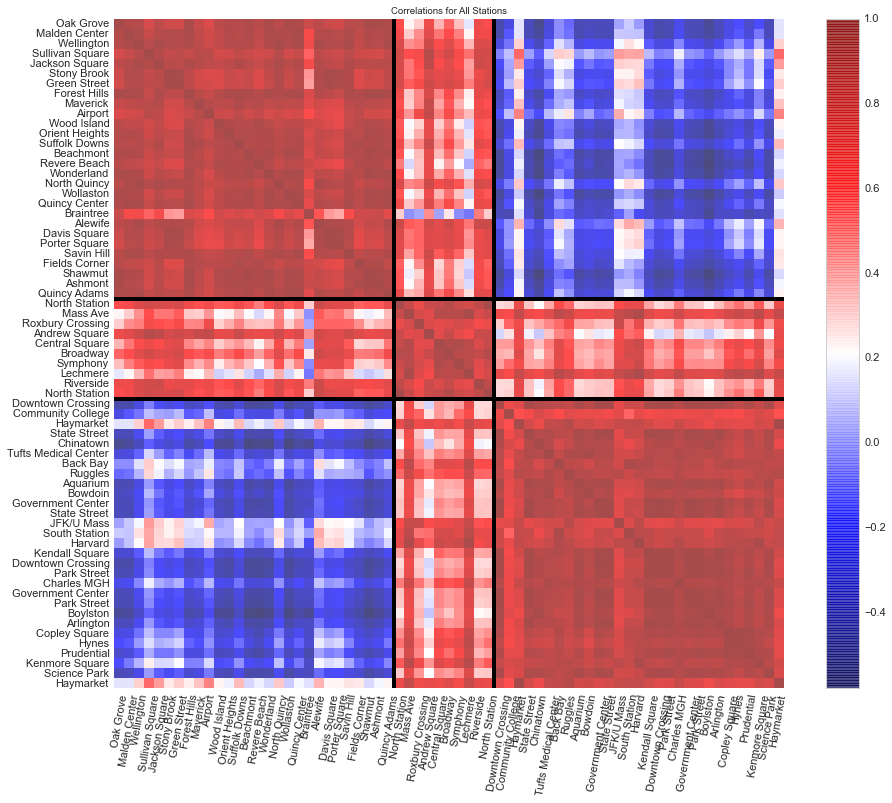

In [117]:
station_names=map(get_name,temp_ids)

fig, ax = plt.subplots()
heatmap = ax.pcolor(pd.DataFrame(correlation_vectors),cmap=plt.get_cmap('seismic'),alpha=0.7)
fig = plt.gcf()
fig.set_size_inches(15,12)

# Clip the axes to remove white border
plt.ylim(0, len(temp_ids))
plt.xlim(0, len(temp_ids))

#invert so we orient the diagonal properly
ax.invert_yaxis()
ax.grid(False)
ax.set_frame_on(False)

# reorganize the ticks
ax.set_yticks(np.arange(len(temp_ids)) + 0.5, minor=False)
ax.set_xticks(np.arange(len(temp_ids))+0.5, minor=False) 
#put labels on the ticks
ax.set_xticklabels(station_names, minor=False)
ax.set_yticklabels(station_names, minor=False)

plt.xticks(rotation=80)
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)
plt.title('Correlations for All Stations')
colorbar=plt.colorbar(heatmap)

# plot lines for the groups
plt.axhline(y=len(group_1_ids),xmin=0,xmax=(len(temp_ids)),color='black',linewidth=4)
plt.axhline(y=len(group_1_ids)+len(group_2_ids),xmin=0,xmax=(len(temp_ids)),color='black',linewidth=4)

plt.axvline(x=len(group_1_ids),ymin=0,ymax=(len(temp_ids)),color='black',linewidth=4)
plt.axvline(x=len(group_1_ids)+len(group_2_ids),ymin=0,ymax=(len(temp_ids)),color='black',linewidth=4)

plt.savefig('all_stations.png',format='png')
plt.show()


###Comments:
The top group of stations is group1, the middle is group 2, and the bottom is group 0 when looking at box plots for the stations later on.

In [118]:
##Save Groupings!
global_group_0=group_0_ids
global_group_1=group_1_ids
global_group_2=group_2_ids

In [138]:
station_info=pd.read_csv('../../../data/Stations_clean.csv')

In [139]:
grouping_dict={}

for station in global_group_0:
    grouping_dict[station]=0
    
for station in global_group_1:
    grouping_dict[station]=1
    
for station in global_group_2:
    grouping_dict[station]=2
   
#want to map station id to column for grouping
def group_col(station_id):
    return grouping_dict[station_id]

station_info['grouping']=map(group_col,station_info['stationid'].values)

station_info.head()

,Unnamed: 0,stationid,nameshort,namelong,name,line_temp,grouping
0,20,1002,Andrew Square,1002,Andrew Square,Red,2
1,21,1004,JFK/U Mass,1004,JFK/U Mass,Red,0
2,22,1005,North Quincy,1005,North Quincy,Red,1
3,23,1006,Wollaston,1006,Wollaston,Red,1
4,24,1007,Quincy Center,1007,Quincy Center,Red,1


In [130]:
##read in a stations csv with lat/long values
stations_latlong=pd.read_csv('../../../data/stations_with_dist.csv')
stations_latlong.head()

,Unnamed: 0,locationid,name,lat,lon,dist_to_center
0,0,1002,Andrew Square,42.329550,-71.056960,3.404767
1,1,1004,JFK/U Mass,42.321438,-71.052393,4.328881
2,2,1005,North Quincy,42.274816,-71.029176,9.777437
3,3,1006,Wollaston,42.265615,-71.019402,10.976943
4,4,1007,Quincy Center,42.250879,-71.004798,12.909591


In [132]:
latlong=stations_latlong[['locationid','dist_to_center']]

In [140]:
station_info=station_info.merge(latlong,left_on='stationid',right_on='locationid')

#station_info=station_info[['stationid','nameshort','namelong','name','line_temp','grouping','dist_to_center']]
station_info.head()

,Unnamed: 0,stationid,nameshort,namelong,name,line_temp,grouping,locationid,dist_to_center
0,20,1002,Andrew Square,1002,Andrew Square,Red,2,1002,3.404767
1,21,1004,JFK/U Mass,1004,JFK/U Mass,Red,0,1004,4.328881
2,22,1005,North Quincy,1005,North Quincy,Red,1,1005,9.777437
3,23,1006,Wollaston,1006,Wollaston,Red,1,1006,10.976943
4,24,1007,Quincy Center,1007,Quincy Center,Red,1,1007,12.909591


In [151]:
station_info=station_info[['stationid','name','line_temp','grouping','dist_to_center']]
station_info.head()

station_info.to_csv('../../../data/Stations_clean.csv')

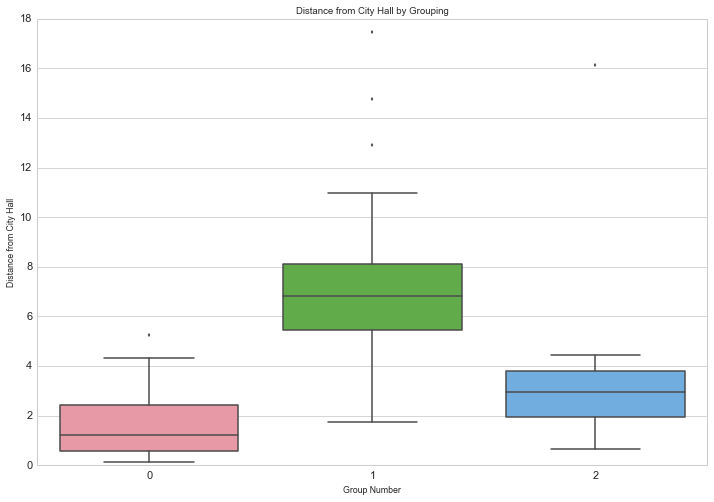

In [144]:
plt.figure(figsize=(12,8))

sns.boxplot(station_info['dist_to_center'],groupby=station_info['grouping'])
plt.xlabel('Group Number')
plt.ylabel('Distance from City Hall')
plt.title('Distance from City Hall by Grouping')
plt.show()

In [148]:
print "Group 0 stations: "+ ', '.join(map(get_name,group_0_ids))
print
print "Group 1 stations: "+ ', '.join(map(get_name,group_1_ids))
print
print "Group 2 stations: "+ ', '.join(map(get_name,group_2_ids))

Group 0 stations: Downtown Crossing, Community College, Haymarket, State Street, Chinatown, Tufts Medical Center, Back Bay, Ruggles, Aquarium, Bowdoin, Government Center, State Street, JFK/U Mass, South Station, Harvard, Kendall Square, Downtown Crossing, Park Street, Charles MGH, Government Center, Park Street, Boylston, Arlington, Copley Square, Hynes, Prudential, Kenmore Square, Science Park, Haymarket

Group 1 stations: Oak Grove, Malden Center , Wellington , Sullivan Square, Jackson Square, Stony Brook, Green Street, Forest Hills, Maverick, Airport, Wood Island, Orient Heights, Suffolk Downs, Beachmont, Revere Beach, Wonderland, North Quincy, Wollaston, Quincy Center, Braintree, Alewife, Davis Square, Porter Square, Savin Hill, Fields Corner, Shawmut, Ashmont, Quincy Adams

Group 2 stations: North Station, Mass Ave, Roxbury Crossing, Andrew Square, Central Square, Broadway, Symphony, Lechmere, Riverside, North Station


###Question:
Which station is most dissimilar to all others? AKA which station has the lowest average correlation with all other stations? Omit correlations within own group..

By looking at correlations with stations not in your own group, it seems that the most dissimilar station will be from the bottom half of the matrix (Downtown Crossing...Haymarket).

In [90]:
# Group 0 is our group of interest. Check the lengths
print len(group_0_ids)

#grab the appropriate correlation vectors
print len(correlation_vectors[len(group_2_ids)+len(group_1_ids):])

group_0_corr=correlation_vectors[len(group_2_ids)+len(group_1_ids):]

#get only the columns corresponding to groups 1 and 2
group_0_corr=(np.array(group_0_corr).transpose()[:len(group_2_ids)+len(group_1_ids)-1]).transpose()

group_0_corr_means=np.mean(group_0_corr,axis=1)

#store index where min occurs in group_0 ids
min_station_index=np.where(np.min(group_0_corr_means)==group_0_corr_means)[0][0]
print group_0_ids[min_station_index]
print "The most 'dissimilar' station is "+get_name(group_0_ids[min_station_index])+" with correlation of "+str(group_0_corr_means[min_station_index])+" on stations not in the same grouping"

29
29
1078
The most 'dissimilar' station is Chinatown with correlation of -0.229703391339 on stations not in the same grouping



##Plotting Dist from center vs. AM/PM Ratio 

In [171]:

subset=gatecount_1315[gatecount_1315['weekday']<5]

am_rush_bool=((subset['servicetime_fraction']>=6.5) & (subset['servicetime_fraction']<=9.5))
pm_rush_bool=((subset['servicetime_fraction']>=16.5) & (subset['servicetime_fraction']<=19.5))

subset['am_rush']=am_rush_bool
subset['pm_rush']=pm_rush_bool

subset['rush_hour']= (am_rush_bool | pm_rush_bool)

subset=subset[subset['rush_hour']==True]
subset.head()


,Unnamed: 0,locationid,entries,exits,servicedate,servicetime_fraction,weekday,am_rush,pm_rush,rush_hour
7,7,1002,19,4,2013-01-01 00:00:00,6.50,1,True,False,True
8,8,1002,9,5,2013-01-01 00:00:00,6.75,1,True,False,True
9,9,1002,14,3,2013-01-01 00:00:00,7.00,1,True,False,True
10,10,1002,23,6,2013-01-01 00:00:00,7.25,1,True,False,True
11,11,1002,11,3,2013-01-01 00:00:00,7.50,1,True,False,True


In [182]:
subset_2=subset[['locationid','entries','servicedate','am_rush']].groupby(['locationid','servicedate','am_rush']).agg(np.sum)
subset_2=subset_2.reset_index()

subset_3=subset_2[['locationid','am_rush','entries']].groupby(['am_rush','locationid']).agg(np.mean)

pm_rush_mean=subset_3.loc[False]['entries']

ratio_subset=subset_3.loc[True]
ratio_subset['pm_entries']=pm_rush_mean

# in ratio subset, 'entries' is the mean am rush hour entries for that station
ratio_subset['am_pm_ratio']=ratio_subset['entries']/ratio_subset['pm_entries']

ratio_subset=ratio_subset.reset_index()
ratio_subset.head()


,locationid,entries,pm_entries,am_pm_ratio
0,1002,1743.633880,1137.439781,1.532946
1,1004,1682.384755,2074.090744,0.811143
2,1005,3001.119782,942.152727,3.185386
3,1006,2260.174545,339.927405,6.648992
4,1007,3708.607273,871.707273,4.254418


In [184]:
ratio_subset=ratio_subset.merge(station_info, left_on='locationid',right_on='stationid')
ratio_subset.head()

,locationid,entries,pm_entries,am_pm_ratio,stationid,name,line_temp,grouping,dist_to_center
0,1002,1743.633880,1137.439781,1.532946,1002,Andrew Square,Red,2,3.404767
1,1004,1682.384755,2074.090744,0.811143,1004,JFK/U Mass,Red,0,4.328881
2,1005,3001.119782,942.152727,3.185386,1005,North Quincy,Red,1,9.777437
3,1006,2260.174545,339.927405,6.648992,1006,Wollaston,Red,1,10.976943
4,1007,3708.607273,871.707273,4.254418,1007,Quincy Center,Red,1,12.909591


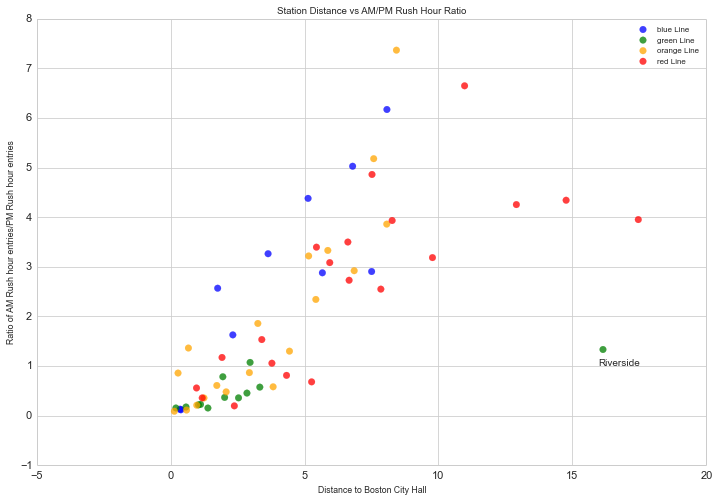

In [210]:
plt.figure(figsize=(12,8))

for i,group in ratio_subset.groupby('line_temp'):
    group_line=group['line_temp'].iloc[0].lower()
    plt.scatter(group['dist_to_center'],group['am_pm_ratio'], s=45,alpha=0.75,color=group_line,label=group_line+' Line')

plt.xlabel('Distance to Boston City Hall')
plt.ylabel('Ratio of AM Rush hour entries/PM Rush hour entries')
plt.legend()
plt.title('Station Distance vs AM/PM Rush Hour Ratio')
plt.annotate('Riverside',xy=(16,1))

plt.show()

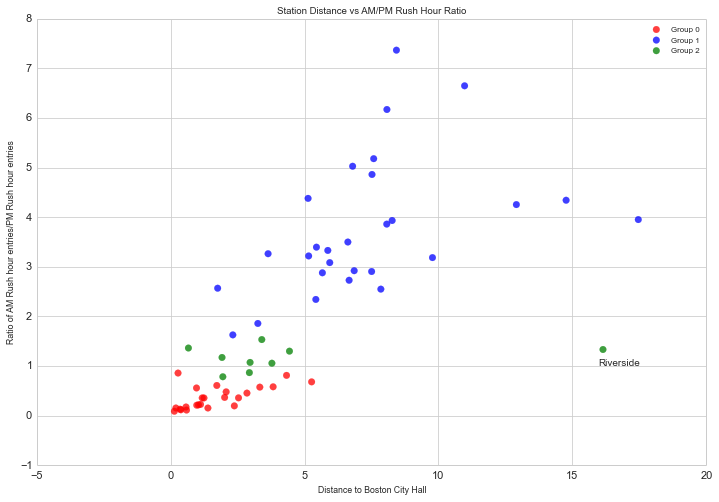

In [208]:
plt.figure(figsize=(12,8))
color_dict={0:'red',1:'blue',2:'green'}

for i,group in ratio_subset.groupby('grouping'):
    group_num=group['grouping'].iloc[0]
    plt.scatter(group['dist_to_center'],group['am_pm_ratio'], s=45,alpha=0.75,color=color_dict[group_num],label='Group '+str(group_num))

plt.xlabel('Distance to Boston City Hall')
plt.ylabel('Ratio of AM Rush hour entries/PM Rush hour entries')
plt.legend()
plt.title('Station Distance vs AM/PM Rush Hour Ratio')
plt.annotate('Riverside',xy=(16,1))

plt.show()